In [9]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
print(os.listdir("chest_xray/"))

['.DS_Store', 'test', 'train', 'val']


In [44]:
Training_set_dir = "chest_xray/train/"
Testing_set_dir = "chest_xray/test/"

In [27]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith("."):
            if nextDir in ["NORMAL"]:
                label = 0
            elif nextDir in ["PNEUMONIA"]:
                label = 1
            temp = Dir + "/" + nextDir
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + "/" + file)
                if img is not None:
                    img = skimage.transform.resize(img,(150,150,3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [93]:
X_train, y_train = get_data(Training_set_dir)

100%|█████████████████████████████████████████████████████████████████████████████████████| 3876/3876 [14:18<00:00,  4.51it/s]


In [99]:
X_test , y_test = get_data(Testing_set_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████| 390/390 [01:03<00:00,  6.17it/s]


In [98]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


print(y_train.shape)

(5216, 150, 150, 3) (5216,)
(624, 150, 150, 3) (624,)
(5216,)


In [108]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [109]:
Pimages = os.listdir(Training_set_dir + "PNEUMONIA")
Nimages = os.listdir(Training_set_dir + "NORMAL")

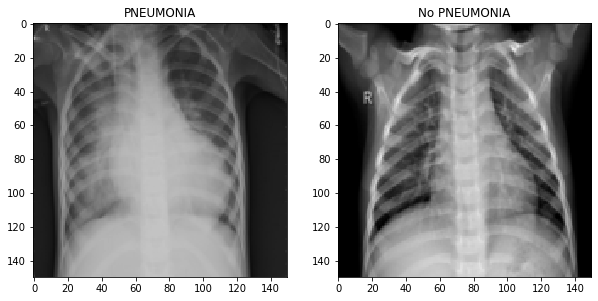

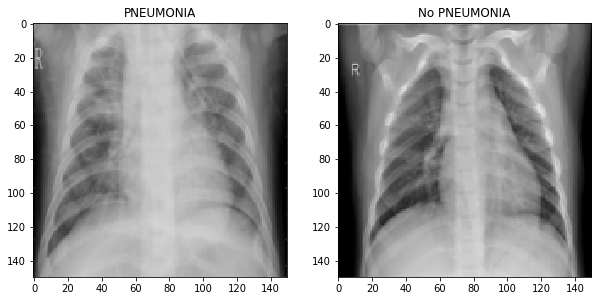

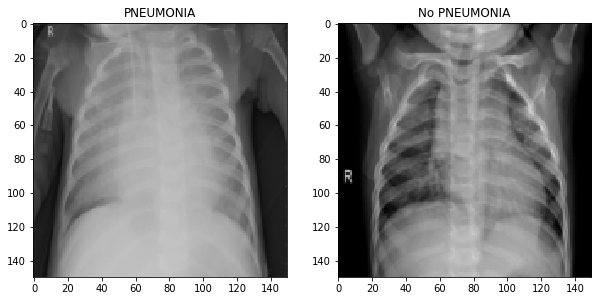

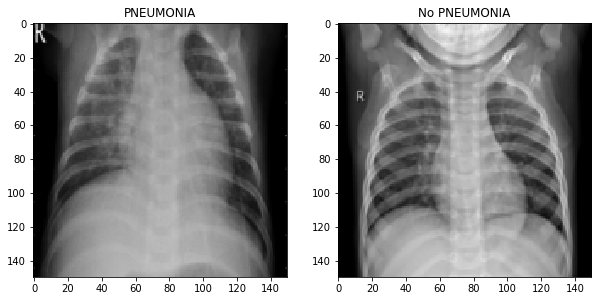

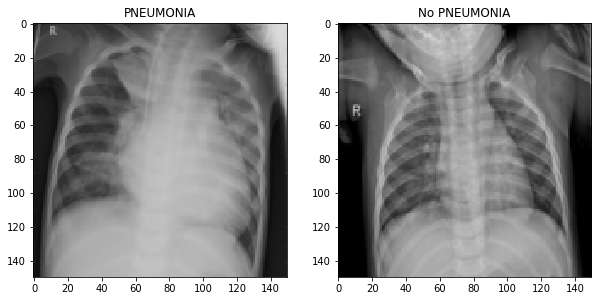

In [110]:
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(Training_set_dir+"PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(Training_set_dir+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    
    fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(10, 5))
    axs[0].set_title('PNEUMONIA')
    axs[0].imshow(imagep1)

    axs[1].set_title('No PNEUMONIA')
    axs[1].imshow(imagen1)
    plt.show()
for i in range(5,10):
    plotter(i)

In [111]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

In [112]:
filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [113]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.image_data_format()
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [114]:
X_train=X_train.reshape(5216,150,150,3)
X_test=X_test.reshape(624,150,150,3)

In [115]:
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights=None, include_top=False , input_shape= (150, 150,3))

In [121]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

In [122]:
model = Model(inputs=base_model.input, outputs=predictions)


In [123]:
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

In [125]:
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_193 (BatchN (None, 74, 74, 32)   96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 74, 74, 32)   0           batch_normalization_193[0][0]    
____________________________________________________________________________________________

In [89]:
batch_size = 64
epochs = 10

In [126]:
print(y_train.shape)
print(y_test.shape)
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

(5216, 2)
(624, 2)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5216 samples, validate on 624 samples
Epoch 1/10
5216/5216 [==============================] - ETA: 1:58:21 - loss: 0.8657 - acc: 0.43 - ETA: 1:16:12 - loss: 0.8181 - acc: 0.45 - ETA: 1:02:12 - loss: 0.7576 - acc: 0.54 - ETA: 54:47 - loss: 0.6484 - acc: 0.6094 - ETA: 50:11 - loss: 0.6356 - acc: 0.61 - ETA: 46:52 - loss: 0.5995 - acc: 0.63 - ETA: 44:23 - loss: 0.5662 - acc: 0.63 - ETA: 42:37 - loss: 0.5307 - acc: 0.66 - ETA: 41:18 - loss: 0.5372 - acc: 0.66 - ETA: 40:00 - loss: 0.5155 - acc: 0.68 - ETA: 38:57 - loss: 0.5054 - acc: 0.69 - ETA: 38:02 - loss: 0.4913 - acc: 0.69 - ETA: 37:12 - loss: 0.4821 - acc: 0.70 - ETA: 36:30 - loss: 0.4707 - acc: 0.71 - ETA: 35:49 - loss: 0.4633 - acc: 0.72 - ETA: 35:14 - loss: 0.4598 - acc: 0.72 - ETA: 34:43 - loss: 0.4600 - acc: 0.71 - ETA: 34:12 - loss: 0.4555 - acc: 0.72 - ETA: 33:41 - loss: 0.4542 - acc: 0.72 - ETA: 33:11 - los

In [127]:
model.load_weights("transferlearning_weights.hdf5")


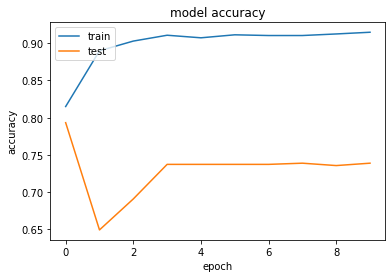

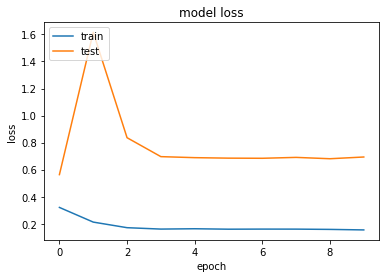

In [128]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [129]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

In [130]:
print(pred.shape)

(624,)


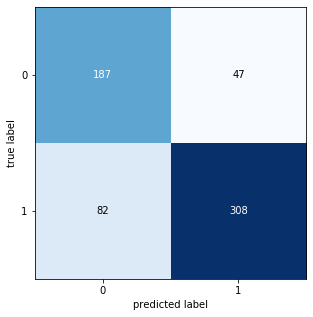

In [132]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()